In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import optuna

df=pd.read_csv('/kaggle/input/bank-client-attributes-and-marketing-outcomes/Assignment-2_Data.csv')
df.head()

,Id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1001,NaN,management,married,tertiary,no,2143.0,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,1002,NaN,NaN,single,secondary,no,29.0,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,1003,NaN,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,1004,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,1005,33.0,unknown,single,unknown,no,1.0,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [2]:
df.drop('Id',axis=1,inplace=True)
df['month']=pd.to_datetime(df['month'], format='%b').dt.month.astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        45199 non-null  float64
 1   job        45210 non-null  object 
 2   marital    45211 non-null  object 
 3   education  45211 non-null  object 
 4   default    45211 non-null  object 
 5   balance    45208 non-null  float64
 6   housing    45211 non-null  object 
 7   loan       45211 non-null  object 
 8   contact    45211 non-null  object 
 9   day        45211 non-null  int64  
 10  month      45211 non-null  int64  
 11  duration   45211 non-null  int64  
 12  campaign   45211 non-null  int64  
 13  pdays      45211 non-null  int64  
 14  previous   45211 non-null  int64  
 15  poutcome   45211 non-null  object 
 16  y          45211 non-null  object 
dtypes: float64(2), int64(6), object(9)
memory usage: 5.9+ MB


In [3]:
df.duplicated().sum()

0

In [4]:
df.isna().sum()

age          12
job           1
marital       0
education     0
default       0
balance       3
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
y             0
dtype: int64

In [5]:
df.dropna(inplace=True,ignore_index=True)
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [6]:
X=df.drop('y',axis=1)
y=df['y']
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((36157, 16), (9040, 16), (36157,), (9040,))

In [7]:
x_train.describe()

,age,balance,day,month,duration,campaign,pdays,previous
count,36157.000000,36157.000000,36157.000000,36157.000000,36157.000000,36157.000000,36157.000000,36157.000000
mean,40.940675,1363.607324,15.805764,6.139420,256.826977,2.765578,40.509694,0.586525
std,10.598572,3027.672744,8.320179,2.408327,255.775383,3.090760,100.516981,2.410281
min,-1.000000,-6847.000000,1.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,74.000000,8.000000,5.000000,102.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,6.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1429.000000,21.000000,8.000000,318.000000,3.000000,-1.000000,0.000000
max,95.000000,98417.000000,31.000000,12.000000,4918.000000,63.000000,871.000000,275.000000


negative age (?)

negative balance (?)

duration 0 (?)

pdays -1 (?)

In [8]:
def covariate_transform(df: pd.DataFrame) -> pd.DataFrame:
    df.age=df.age.apply(lambda x: 18 if x<18 else x) #assume minimal age of a client is 18 y.o
    df.balance=df.balance.apply(lambda x: 0 if x<0 else x) #assume there is no minimal balance (?)
    df.duration=df.duration.apply(lambda x: 1 if x<1 else x) #i'm not really sure what duration means here, but i assume duration must be greater than 0 (?)
    df.pdays=df.pdays.apply(lambda x: 1 if x<1 else x) #again i'm not really sure what pdays means here, but i assume it means "previous days" (?), so i think it should be greater than 0
    return df

In [9]:
x_train=covariate_transform(x_train)
x_test=covariate_transform(x_test)
x_train.describe()

,age,balance,day,month,duration,campaign,pdays,previous
count,36157.000000,36157.000000,36157.000000,36157.000000,36157.000000,36157.000000,36157.000000,36157.000000
mean,40.941726,1389.431535,15.805764,6.139420,256.827032,2.765578,42.141909,0.586525
std,10.595355,3012.971871,8.320179,2.408327,255.775327,3.090760,99.843650,2.410281
min,18.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,33.000000,74.000000,8.000000,5.000000,102.000000,1.000000,1.000000,0.000000
50%,39.000000,448.000000,16.000000,6.000000,180.000000,2.000000,1.000000,0.000000
75%,48.000000,1429.000000,21.000000,8.000000,318.000000,3.000000,1.000000,0.000000
max,95.000000,98417.000000,31.000000,12.000000,4918.000000,63.000000,871.000000,275.000000


In [10]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36157 entries, 9324 to 15795
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        36157 non-null  float64
 1   job        36157 non-null  object 
 2   marital    36157 non-null  object 
 3   education  36157 non-null  object 
 4   default    36157 non-null  object 
 5   balance    36157 non-null  float64
 6   housing    36157 non-null  object 
 7   loan       36157 non-null  object 
 8   contact    36157 non-null  object 
 9   day        36157 non-null  int64  
 10  month      36157 non-null  int64  
 11  duration   36157 non-null  int64  
 12  campaign   36157 non-null  int64  
 13  pdays      36157 non-null  int64  
 14  previous   36157 non-null  int64  
 15  poutcome   36157 non-null  object 
dtypes: float64(2), int64(6), object(8)
memory usage: 4.7+ MB


In [11]:
cat_col=list(x_train.select_dtypes(include='object').columns)
num_col=list(set(x_train.columns.values)-set(cat_col))

In [12]:
for col in cat_col:
    print(f'{col}: ',x_train[col].unique())

job:  ['unknown' 'blue-collar' 'technician' 'unemployed' 'admin.' 'management'
 'services' 'entrepreneur' 'retired' 'self-employed' 'housemaid' 'student']
marital:  ['single' 'married' 'divorced']
education:  ['secondary' 'unknown' 'tertiary' 'primary']
default:  ['no' 'yes']
housing:  ['no' 'yes']
loan:  ['no' 'yes']
contact:  ['unknown' 'cellular' 'telephone']
poutcome:  ['unknown' 'other' 'failure' 'success']


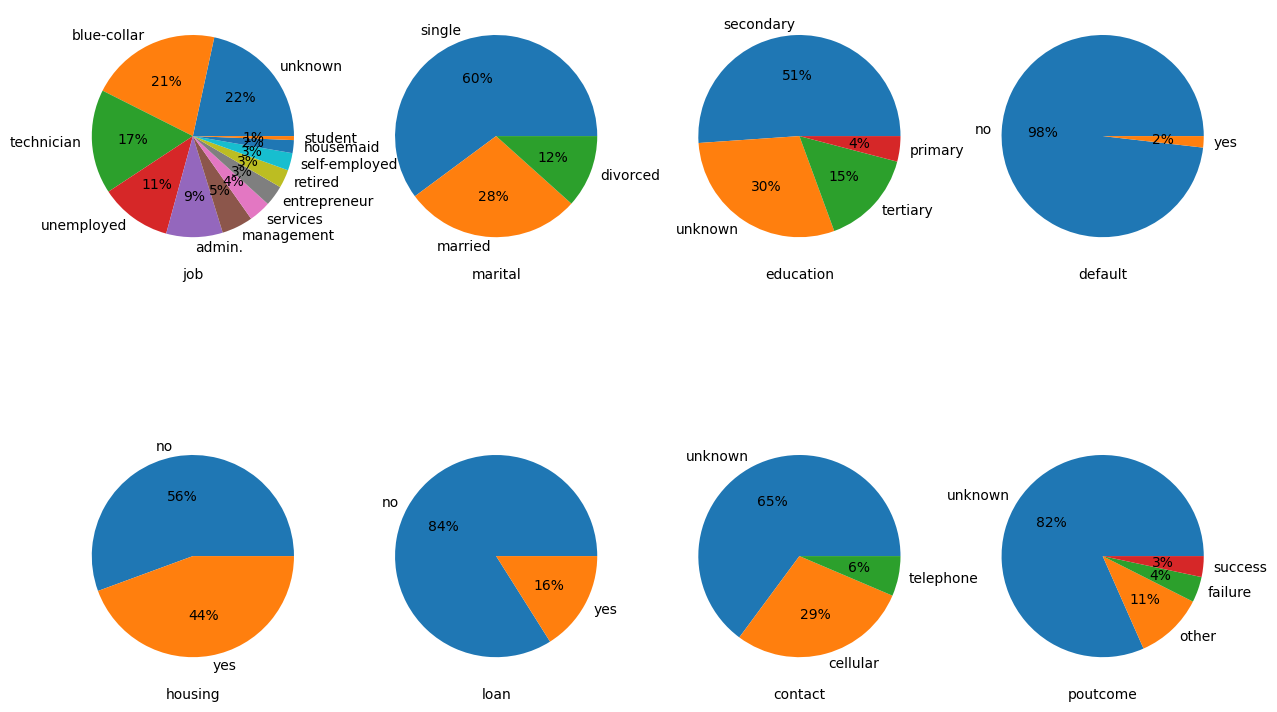

In [13]:
_, ax = plt.subplots(2, 4, figsize=(15,10))
for i in range(len(cat_col)):
    fracs=list(x_train[cat_col[i]].value_counts().values)
    ax[i//4,i%4].pie(x=fracs,labels=x_train[cat_col[i]].unique(),autopct='%.0f%%')
    ax[i//4,i%4].set_xlabel(cat_col[i])

In [14]:
#chi2 independency test
for col in cat_col:
    tab=pd.crosstab(x_train[col],y_train)
    if st.chi2_contingency(tab)[1]<0.05:
        print(f'{col}: significant')
    else:
        print(f'{col}: not enough proof')

job: significant
marital: significant
education: significant
default: significant
housing: significant
loan: significant
contact: significant
poutcome: significant


<Axes: >

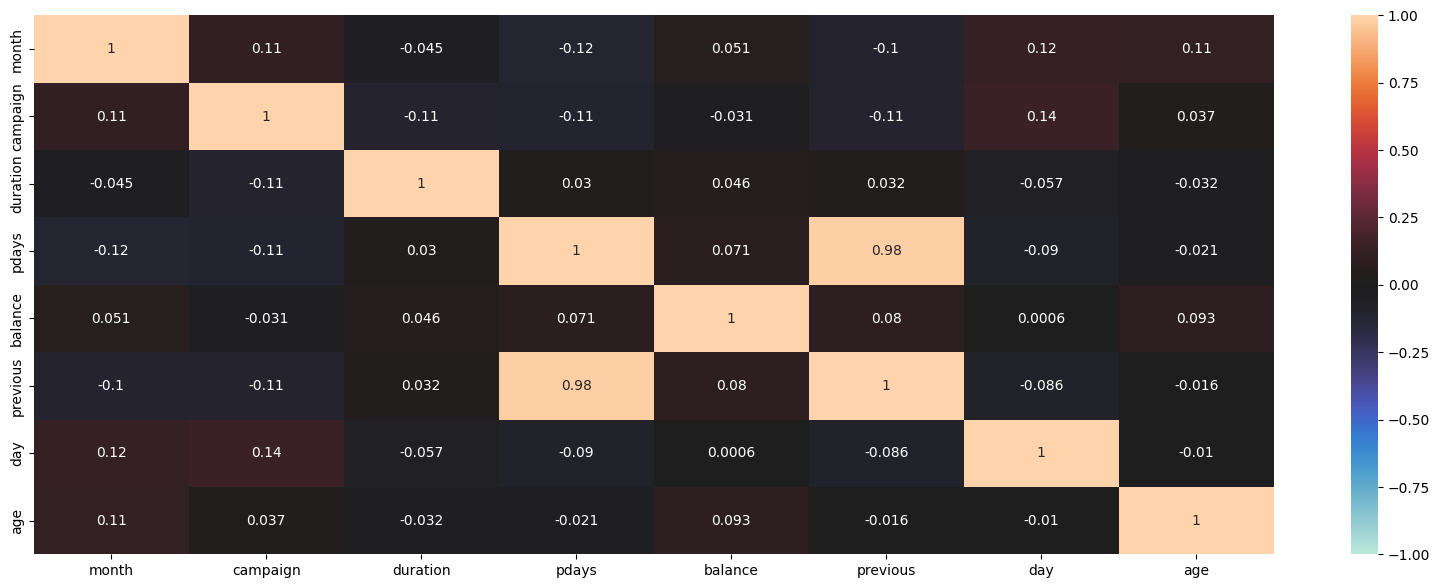

In [15]:
plt.figure(figsize=(20, 7))
sns.heatmap(x_train.loc[:,num_col].corr(method='spearman'),vmin=-1,vmax=1,center=0,annot=True)

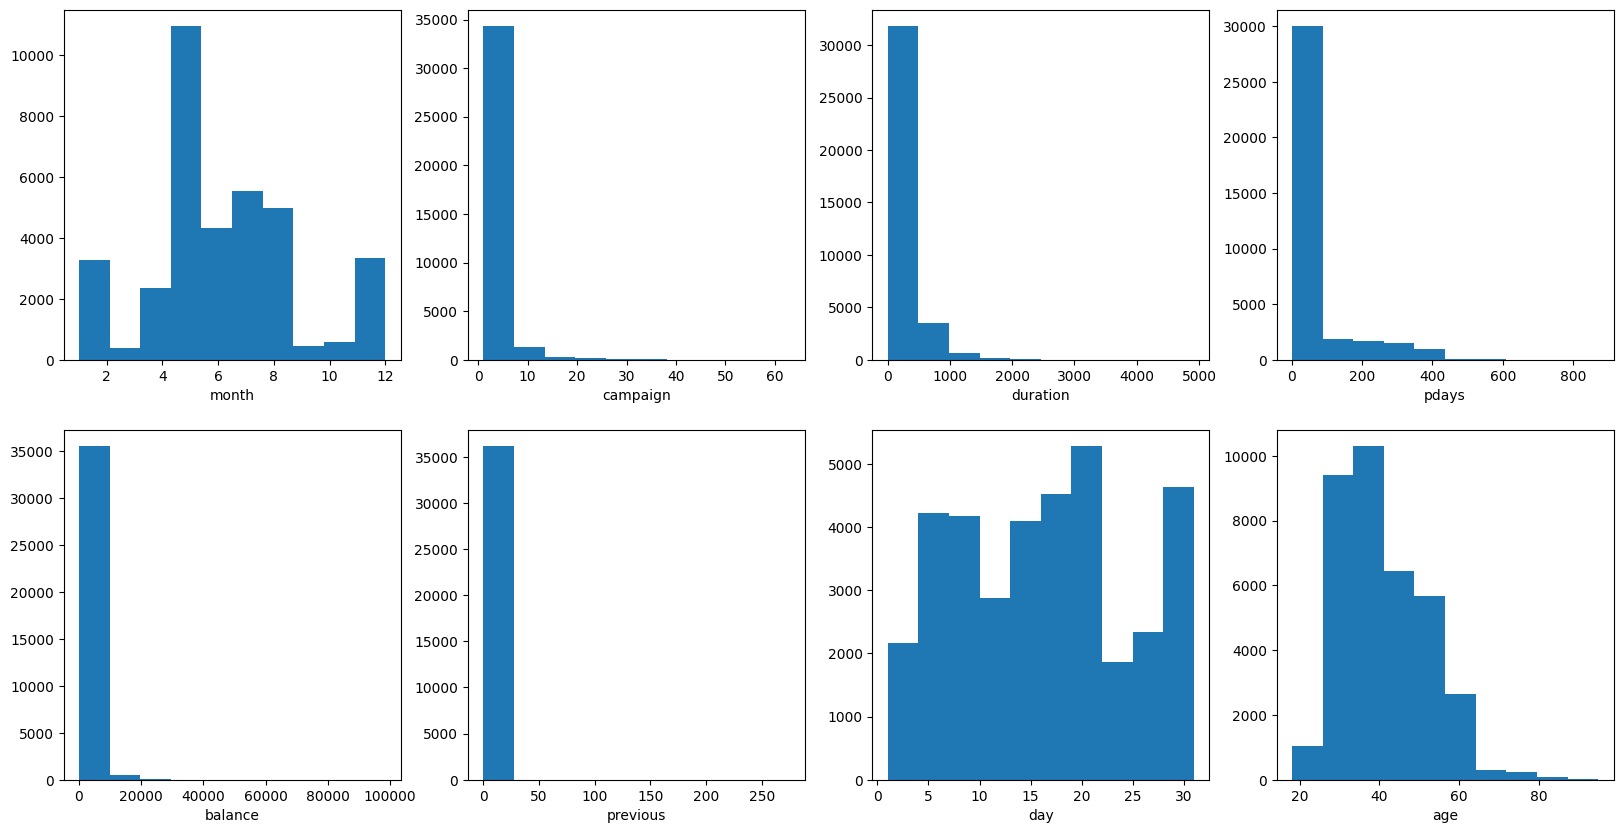

In [16]:
_, ax = plt.subplots(2, 4, figsize=(20,10))
for i in range(len(num_col)):
    ax[i//4,i%4].hist(x_train[num_col[i]])
    ax[i//4,i%4].set_xlabel(num_col[i])

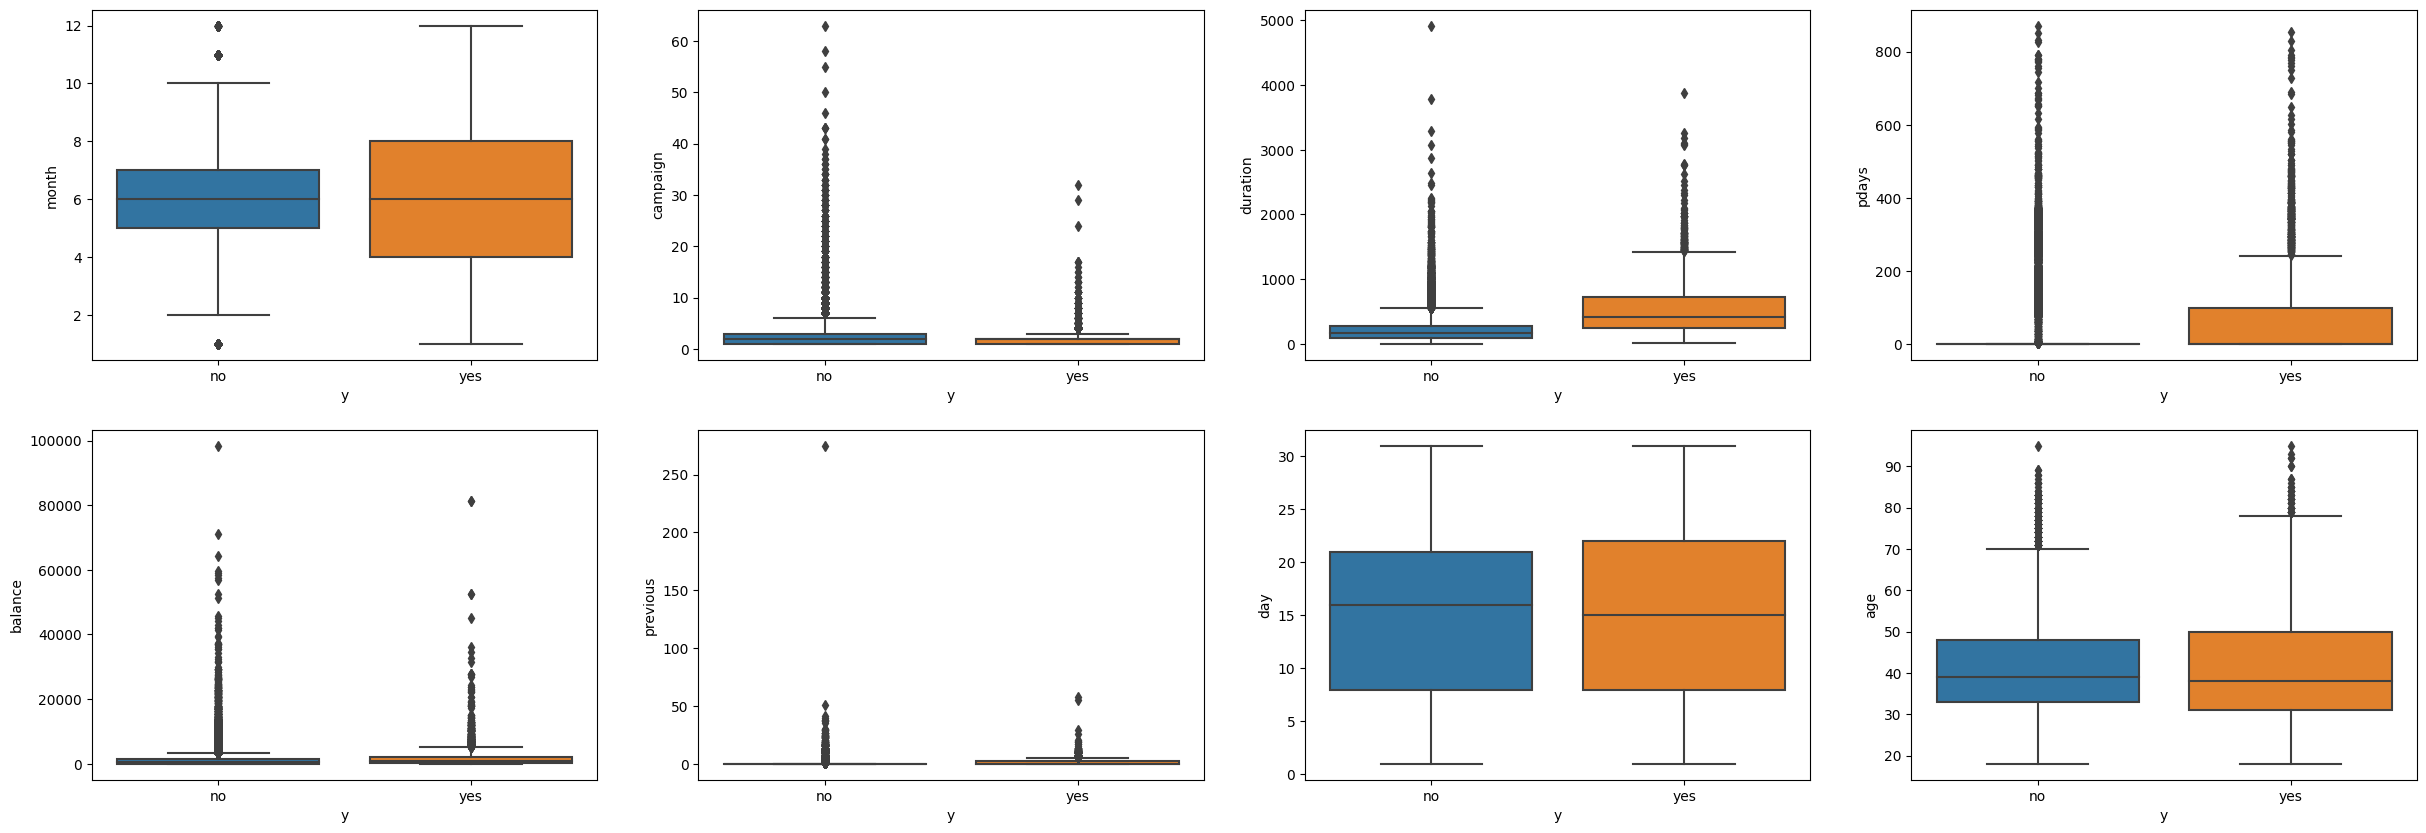

In [17]:
_, ax = plt.subplots(2, 4, figsize=(30,10))
for i in range(len(num_col)):
    sns.boxplot(x=y_train,y=x_train[num_col[i]],ax=ax[i//4,i%4])

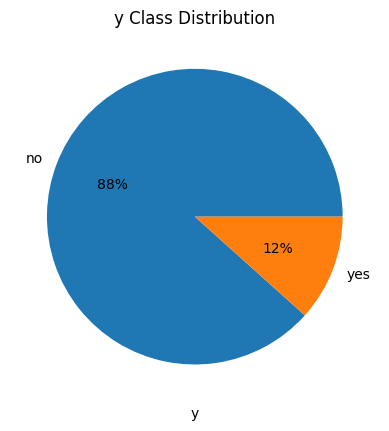

In [18]:
plt.pie(x=y_train.value_counts().values,labels=y_train.unique(),autopct='%.0f%%')
plt.xlabel('y')
plt.title('y Class Distribution')
plt.show()

In [19]:
x_train=pd.get_dummies(x_train,columns=cat_col,dtype='float',drop_first=True)
x_test=pd.get_dummies(x_test,columns=cat_col,dtype='float',drop_first=True)
x_train.head()

,age,balance,day,month,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,...,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
9324,39.0,0.0,6,6,188,1,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
44949,37.0,1403.0,9,10,14,1,1,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4194,36.0,79.0,19,5,201,14,1,0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
20382,33.0,335.0,11,8,566,7,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4497,35.0,0.0,20,5,265,1,1,0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [20]:
target_class={'no':0,'yes':1}
y_train=y_train.apply(lambda x: target_class[x])
y_test=y_test.apply(lambda x: target_class[x])

In [21]:
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
scaler=MinMaxScaler()
scaler.set_output(transform='pandas')
sm=SMOTE(k_neighbors=10,random_state=42)
cv=StratifiedKFold(5,shuffle=True,random_state=42)

In [22]:
def objective(trial):
    depth=trial.suggest_int("max_depth",6,20,step=1)
    estimators=trial.suggest_int("n_estimators",100,900,step=100)
    subsample=trial.suggest_float("subsample",0.5,1,step=0.1)
    colsample=trial.suggest_float("colsample_bytree",0.5,1,step=0.1)
    reg_alpha=trial.suggest_float("reg_alpha",0,2e-1,step=0.025)
    reg_lambda=trial.suggest_float("reg_lambda",0,2e-1,step=0.025)
    leaves=trial.suggest_int("num_leaves",12,40,step=2)
    lr=trial.suggest_float("learning_rate",0.05,0.3,step=0.05)
    bin_sample=trial.suggest_int("subsample_for_bin",200000,400000,step=16)

    model=LGBMClassifier(num_leaves=leaves,
                     max_depth=depth,
                     learning_rate=lr,
                     n_estimators=estimators,
                     subsample=subsample,
                     colsample_bytree=colsample,
                     reg_alpha=reg_alpha,
                     reg_lambda=reg_lambda,
                     subsample_for_bin=bin_sample,
                     n_jobs=-1,
                     random_state=42)
    scores=[]
    for fold,(train,val) in enumerate(cv.split(x_train,y_train)):
        X,y=x_train.copy(),y_train.copy()
        x_train1,y_train1,x_val,y_val=X.iloc[train],y.iloc[train],X.iloc[val],y.iloc[val]
        x_train1=scaler.fit_transform(x_train1)
        x_val=scaler.transform(x_val)
        x_train1,y_train1=sm.fit_resample(x_train1,y_train1)
        model.fit(x_train1,y_train1)
        scores.append(f1_score(y_val,model.predict(x_val)))
    return np.mean(scores)

In [23]:
sampler=optuna.samplers.TPESampler(seed=42)
study=optuna.create_study(sampler=sampler,direction='maximize')
study.optimize(objective,n_trials=30)

[I 2024-03-24 10:04:08,466] A new study created in memory with name: no-name-1e07698c-474b-4178-b4ea-001ec4454b70


[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6804
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6802
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

[I 2024-03-24 10:04:42,395] Trial 0 finished with value: 0.5668173500483246 and parameters: {'max_depth': 11, 'n_estimators': 900, 'subsample': 0.9, 'colsample_bytree': 0.8, 'reg_alpha': 0.025, 'reg_lambda': 0.025, 'num_leaves': 12, 'learning_rate': 0.3, 'subsample_for_bin': 320224}. Best is trial 0 with value: 0.5668173500483246.


[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6804
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6802
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of neg

[I 2024-03-24 10:04:49,909] Trial 1 finished with value: 0.6005954688814225 and parameters: {'max_depth': 16, 'n_estimators': 100, 'subsample': 1.0, 'colsample_bytree': 0.9, 'reg_alpha': 0.025, 'reg_lambda': 0.025, 'num_leaves': 16, 'learning_rate': 0.1, 'subsample_for_bin': 304944}. Best is trial 1 with value: 0.6005954688814225.


[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6804
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6802
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing col-wise multi-thre

[I 2024-03-24 10:05:05,495] Trial 2 finished with value: 0.5710499086048427 and parameters: {'max_depth': 12, 'n_estimators': 300, 'subsample': 0.8, 'colsample_bytree': 0.5, 'reg_alpha': 0.05, 'reg_lambda': 0.07500000000000001, 'num_leaves': 24, 'learning_rate': 0.25, 'subsample_for_bin': 239936}. Best is trial 1 with value: 0.6005954688814225.


[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6804
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6802
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of neg

[I 2024-03-24 10:05:38,437] Trial 3 finished with value: 0.5596466441064976 and parameters: {'max_depth': 13, 'n_estimators': 600, 'subsample': 0.5, 'colsample_bytree': 0.8, 'reg_alpha': 0.025, 'reg_lambda': 0.0, 'num_leaves': 40, 'learning_rate': 0.3, 'subsample_for_bin': 361680}. Best is trial 1 with value: 0.6005954688814225.


[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6804
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6802
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing col-wise multi-thre

[I 2024-03-24 10:05:45,040] Trial 4 finished with value: 0.5815112517867871 and parameters: {'max_depth': 10, 'n_estimators': 100, 'subsample': 0.9, 'colsample_bytree': 0.7, 'reg_alpha': 0.025, 'reg_lambda': 0.1, 'num_leaves': 12, 'learning_rate': 0.3, 'subsample_for_bin': 251760}. Best is trial 1 with value: 0.6005954688814225.


[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6804
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6802
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of neg

[I 2024-03-24 10:06:02,516] Trial 5 finished with value: 0.5745886690760273 and parameters: {'max_depth': 15, 'n_estimators': 300, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.025, 'reg_lambda': 0.2, 'num_leaves': 34, 'learning_rate': 0.3, 'subsample_for_bin': 378976}. Best is trial 1 with value: 0.6005954688814225.


[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6804
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6802
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing col-wise multi-thre

[I 2024-03-24 10:06:45,183] Trial 6 finished with value: 0.5663628742567427 and parameters: {'max_depth': 14, 'n_estimators': 900, 'subsample': 0.5, 'colsample_bytree': 0.6, 'reg_alpha': 0.0, 'reg_lambda': 0.05, 'num_leaves': 22, 'learning_rate': 0.1, 'subsample_for_bin': 365760}. Best is trial 1 with value: 0.6005954688814225.


[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6804
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6802
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing col-wise multi-thre

[I 2024-03-24 10:07:03,872] Trial 7 finished with value: 0.5643191884114651 and parameters: {'max_depth': 11, 'n_estimators': 300, 'subsample': 0.8, 'colsample_bytree': 0.5, 'reg_alpha': 0.17500000000000002, 'reg_lambda': 0.0, 'num_leaves': 40, 'learning_rate': 0.25, 'subsample_for_bin': 239744}. Best is trial 1 with value: 0.6005954688814225.


[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6804
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2024-03-24 10:07:45,829] Trial 8 finished with value: 0.5874897600352986 and parameters: {'max_depth': 6, 'n_estimators': 800, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_alpha': 0.15000000000000002, 'reg_lambda': 0.0, 'num_leaves': 22, 'learning_rate': 0.05, 'subsample_for_bin': 372624}. Best is trial 1 with value: 0.6005954688814225.


[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6804
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6802
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing col-wise multi-thre

[I 2024-03-24 10:08:02,108] Trial 9 finished with value: 0.5691058147271763 and parameters: {'max_depth': 15, 'n_estimators': 300, 'subsample': 0.5, 'colsample_bytree': 0.6, 'reg_alpha': 0.05, 'reg_lambda': 0.15000000000000002, 'num_leaves': 30, 'learning_rate': 0.3, 'subsample_for_bin': 294448}. Best is trial 1 with value: 0.6005954688814225.


[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6804
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6802
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

[I 2024-03-24 10:08:09,359] Trial 10 finished with value: 0.594811200278339 and parameters: {'max_depth': 20, 'n_estimators': 100, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'reg_lambda': 0.15000000000000002, 'num_leaves': 18, 'learning_rate': 0.15000000000000002, 'subsample_for_bin': 295856}. Best is trial 1 with value: 0.6005954688814225.


[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6804
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6802
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

[I 2024-03-24 10:08:16,610] Trial 11 finished with value: 0.594811200278339 and parameters: {'max_depth': 20, 'n_estimators': 100, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'reg_lambda': 0.15000000000000002, 'num_leaves': 18, 'learning_rate': 0.15000000000000002, 'subsample_for_bin': 296688}. Best is trial 1 with value: 0.6005954688814225.


[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6804
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6802
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

[I 2024-03-24 10:08:23,756] Trial 12 finished with value: 0.597977705975353 and parameters: {'max_depth': 20, 'n_estimators': 100, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'reg_lambda': 0.15000000000000002, 'num_leaves': 16, 'learning_rate': 0.15000000000000002, 'subsample_for_bin': 327680}. Best is trial 1 with value: 0.6005954688814225.


[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6804
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6802
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

[I 2024-03-24 10:08:47,271] Trial 13 finished with value: 0.5857815273965438 and parameters: {'max_depth': 17, 'n_estimators': 500, 'subsample': 1.0, 'colsample_bytree': 0.9, 'reg_alpha': 0.125, 'reg_lambda': 0.2, 'num_leaves': 18, 'learning_rate': 0.1, 'subsample_for_bin': 328944}. Best is trial 1 with value: 0.6005954688814225.


[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6804
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6802
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

[I 2024-03-24 10:09:11,731] Trial 14 finished with value: 0.5980486450962316 and parameters: {'max_depth': 18, 'n_estimators': 500, 'subsample': 0.7, 'colsample_bytree': 0.9, 'reg_alpha': 0.2, 'reg_lambda': 0.125, 'num_leaves': 14, 'learning_rate': 0.05, 'subsample_for_bin': 270688}. Best is trial 1 with value: 0.6005954688814225.


[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6804
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6802
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

[I 2024-03-24 10:09:45,628] Trial 15 finished with value: 0.5912068156409075 and parameters: {'max_depth': 17, 'n_estimators': 600, 'subsample': 0.6, 'colsample_bytree': 0.9, 'reg_alpha': 0.2, 'reg_lambda': 0.1, 'num_leaves': 28, 'learning_rate': 0.05, 'subsample_for_bin': 269504}. Best is trial 1 with value: 0.6005954688814225.


[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6804
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6802
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of neg

[I 2024-03-24 10:10:08,254] Trial 16 finished with value: 0.5803880678568824 and parameters: {'max_depth': 17, 'n_estimators': 500, 'subsample': 0.7, 'colsample_bytree': 0.9, 'reg_alpha': 0.07500000000000001, 'reg_lambda': 0.05, 'num_leaves': 14, 'learning_rate': 0.1, 'subsample_for_bin': 202624}. Best is trial 1 with value: 0.6005954688814225.


[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6804
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6802
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing col-wise multi-thre

[I 2024-03-24 10:10:44,494] Trial 17 finished with value: 0.5835003809670019 and parameters: {'max_depth': 18, 'n_estimators': 700, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.15000000000000002, 'reg_lambda': 0.125, 'num_leaves': 20, 'learning_rate': 0.05, 'subsample_for_bin': 270128}. Best is trial 1 with value: 0.6005954688814225.


[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6804
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6802
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

[I 2024-03-24 10:11:04,738] Trial 18 finished with value: 0.5855040962013089 and parameters: {'max_depth': 9, 'n_estimators': 400, 'subsample': 0.6, 'colsample_bytree': 0.9, 'reg_alpha': 0.17500000000000002, 'reg_lambda': 0.07500000000000001, 'num_leaves': 14, 'learning_rate': 0.1, 'subsample_for_bin': 211216}. Best is trial 1 with value: 0.6005954688814225.


[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6804
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6802
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

[I 2024-03-24 10:11:16,987] Trial 19 finished with value: 0.5877661990121901 and parameters: {'max_depth': 18, 'n_estimators': 200, 'subsample': 0.6, 'colsample_bytree': 1.0, 'reg_alpha': 0.2, 'reg_lambda': 0.1, 'num_leaves': 26, 'learning_rate': 0.2, 'subsample_for_bin': 348336}. Best is trial 1 with value: 0.6005954688814225.


[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6804
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6802
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of neg

[I 2024-03-24 10:11:43,686] Trial 20 finished with value: 0.5967889692202987 and parameters: {'max_depth': 15, 'n_estimators': 400, 'subsample': 0.7, 'colsample_bytree': 0.8, 'reg_alpha': 0.07500000000000001, 'reg_lambda': 0.05, 'num_leaves': 32, 'learning_rate': 0.05, 'subsample_for_bin': 398784}. Best is trial 1 with value: 0.6005954688814225.


[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6804
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6802
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

[I 2024-03-24 10:11:55,323] Trial 21 finished with value: 0.5926051053958783 and parameters: {'max_depth': 19, 'n_estimators': 200, 'subsample': 0.9, 'colsample_bytree': 1.0, 'reg_alpha': 0.07500000000000001, 'reg_lambda': 0.17500000000000002, 'num_leaves': 16, 'learning_rate': 0.15000000000000002, 'subsample_for_bin': 320672}. Best is trial 1 with value: 0.6005954688814225.


[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6804
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6802
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

[I 2024-03-24 10:12:06,623] Trial 22 finished with value: 0.5831420255696614 and parameters: {'max_depth': 19, 'n_estimators': 200, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.125, 'reg_lambda': 0.125, 'num_leaves': 14, 'learning_rate': 0.2, 'subsample_for_bin': 273056}. Best is trial 1 with value: 0.6005954688814225.


[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6804
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6802
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of neg

[I 2024-03-24 10:12:14,227] Trial 23 finished with value: 0.5980561360707217 and parameters: {'max_depth': 16, 'n_estimators': 100, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_alpha': 0.0, 'reg_lambda': 0.125, 'num_leaves': 16, 'learning_rate': 0.1, 'subsample_for_bin': 341312}. Best is trial 1 with value: 0.6005954688814225.


[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6804
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6802
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

[I 2024-03-24 10:12:26,488] Trial 24 finished with value: 0.5957667128946297 and parameters: {'max_depth': 16, 'n_estimators': 200, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_alpha': 0.0, 'reg_lambda': 0.125, 'num_leaves': 20, 'learning_rate': 0.1, 'subsample_for_bin': 341376}. Best is trial 1 with value: 0.6005954688814225.


[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6804
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6802
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

[I 2024-03-24 10:12:45,658] Trial 25 finished with value: 0.5977217683193257 and parameters: {'max_depth': 16, 'n_estimators': 400, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.0, 'reg_lambda': 0.17500000000000002, 'num_leaves': 12, 'learning_rate': 0.05, 'subsample_for_bin': 305664}. Best is trial 1 with value: 0.6005954688814225.


[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6804
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6802
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

[I 2024-03-24 10:13:12,666] Trial 26 finished with value: 0.5865698290786734 and parameters: {'max_depth': 14, 'n_estimators': 600, 'subsample': 0.7, 'colsample_bytree': 0.9, 'reg_alpha': 0.05, 'reg_lambda': 0.07500000000000001, 'num_leaves': 16, 'learning_rate': 0.1, 'subsample_for_bin': 277600}. Best is trial 1 with value: 0.6005954688814225.


[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6804
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6802
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing col-wise multi-thre

[I 2024-03-24 10:13:47,235] Trial 27 finished with value: 0.5878581275400431 and parameters: {'max_depth': 18, 'n_estimators': 700, 'subsample': 0.9, 'colsample_bytree': 0.7, 'reg_alpha': 0.0, 'reg_lambda': 0.125, 'num_leaves': 22, 'learning_rate': 0.05, 'subsample_for_bin': 311728}. Best is trial 1 with value: 0.6005954688814225.


[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6804
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6802
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

[I 2024-03-24 10:13:59,458] Trial 28 finished with value: 0.5913538811916254 and parameters: {'max_depth': 16, 'n_estimators': 200, 'subsample': 0.8, 'colsample_bytree': 0.9, 'reg_alpha': 0.05, 'reg_lambda': 0.025, 'num_leaves': 20, 'learning_rate': 0.1, 'subsample_for_bin': 344944}. Best is trial 1 with value: 0.6005954688814225.


[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6804
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of negative: 25558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6802
[LightGBM] [Info] Number of data points in the train set: 51116, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 25558, number of neg

[I 2024-03-24 10:14:34,168] Trial 29 finished with value: 0.5739230494559676 and parameters: {'max_depth': 13, 'n_estimators': 900, 'subsample': 1.0, 'colsample_bytree': 0.8, 'reg_alpha': 0.025, 'reg_lambda': 0.025, 'num_leaves': 12, 'learning_rate': 0.15000000000000002, 'subsample_for_bin': 282560}. Best is trial 1 with value: 0.6005954688814225.


In [24]:
study.best_value

0.6005954688814225

In [25]:
best_params=study.best_params
best_params['random_state']=42
best_params['n_jobs']=-1
best_params

{'max_depth': 16,
 'n_estimators': 100,
 'subsample': 1.0,
 'colsample_bytree': 0.9,
 'reg_alpha': 0.025,
 'reg_lambda': 0.025,
 'num_leaves': 16,
 'learning_rate': 0.1,
 'subsample_for_bin': 304944,
 'random_state': 42,
 'n_jobs': -1}

In [26]:
x_train=scaler.fit_transform(x_train)
x_train,y_train=sm.fit_resample(x_train,y_train)
x_test=scaler.transform(x_test)
model=LGBMClassifier(**best_params)
model.fit(x_train,y_train)

[LightGBM] [Info] Number of positive: 31948, number of negative: 31948
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6999
[LightGBM] [Info] Number of data points in the train set: 63896, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(colsample_bytree=0.9, max_depth=16, n_jobs=-1, num_leaves=16,
               random_state=42, reg_alpha=0.025, reg_lambda=0.025,
               subsample_for_bin=304944)

In [27]:
print('F1 Score: ', f1_score(y_test,model.predict(x_test)))
print('Accuracy Score: ', accuracy_score(y_test,model.predict(x_test)))

F1 Score:  0.6023778071334214
Accuracy Score:  0.9001106194690266


In [28]:
def evaluation_parametrics(name,y_val, y_pred):
    
    print("\n------------------------{}------------------------\n".format(name))

    cm_test = confusion_matrix(y_val, y_pred)
    t1 = ConfusionMatrixDisplay(cm_test)    
    print("\nClassification Report\n")
    print(classification_report(y_val, y_pred))   
    print("--------------------------------------------------------------------------")

    t1.plot()


------------------------Confusion Matrix - Test Dataset------------------------


Classification Report

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      7960
           1       0.57      0.63      0.60      1080

    accuracy                           0.90      9040
   macro avg       0.76      0.78      0.77      9040
weighted avg       0.90      0.90      0.90      9040

--------------------------------------------------------------------------


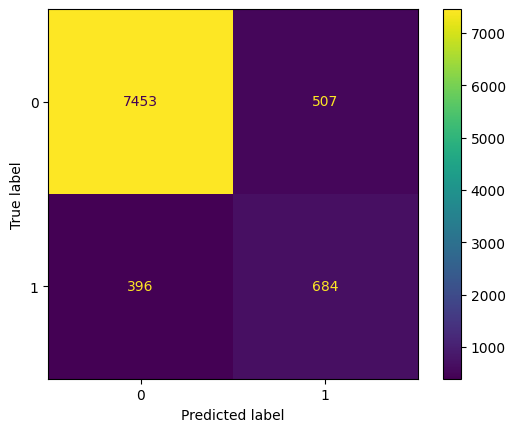

In [29]:
evaluation_parametrics("Confusion Matrix - Test Dataset", y_test, model.predict(x_test))


------------------------Confusion Matrix - Train Dataset------------------------


Classification Report

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     31948
           1       0.94      0.94      0.94     31948

    accuracy                           0.94     63896
   macro avg       0.94      0.94      0.94     63896
weighted avg       0.94      0.94      0.94     63896

--------------------------------------------------------------------------


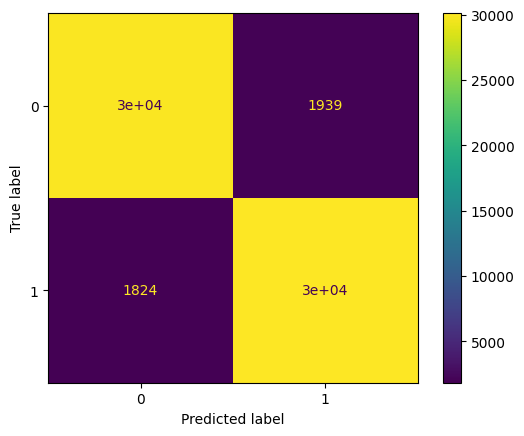

In [30]:
evaluation_parametrics("Confusion Matrix - Train Dataset", y_train, model.predict(x_train))